# Sure Tomorrow

# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: Encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: Predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: Predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: Proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

import math

## Carga de datos

Se procede a cargar los datos y hacer una revisión básica para comprobar que no hay problemas obvios.

In [2]:
df = pd.read_csv('datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
923,1,41.0,32300.0,2,0
4151,0,34.0,44900.0,0,0
19,1,27.0,36900.0,0,0
3621,1,33.0,39800.0,0,0
3310,1,35.0,32400.0,3,0
4726,1,19.0,31700.0,1,0
462,1,19.0,46700.0,3,0
1350,0,19.0,39600.0,1,0
4875,1,18.0,36500.0,3,0
3085,0,32.0,40000.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Procedermos a pasar las columnas "income" y "age" a enteros.

In [6]:
df["income"] = df["income"].astype({'income':'int'})
df["age"] = df["age"].astype({'age':'int'})

Comprobaremos la conversión.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   int64
 1   age                 5000 non-null   int32
 2   income              5000 non-null   int32
 3   family_members      5000 non-null   int64
 4   insurance_benefits  5000 non-null   int64
dtypes: int32(2), int64(3)
memory usage: 156.4 KB


In [8]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


Procederemos a observar las estadísticas descriptivas de la base de datos.

In [10]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Al observar las estadísticas descriptivas de la base de datos, podemos apreciar que existe una distribución homogénea en el género de los clientes, el promedio de edad se encuentra alrededor de los 30 años, los ingresos medios se encuentran alrededor de los 4 mil dólares, la cantidad de miembros de familia se encuentran mayoritariamente entre 0 y 2, existiendo valores anómalos de hasta 6 miembros adicionales. Finalmente podemos observar una distribución desbalanceada en el número de beneficios de la persona asegurada, teniendo 0 beneficios más del 75% de las personas, pero a su vez existiendo clientes con acceso a 5 beneficios. 

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

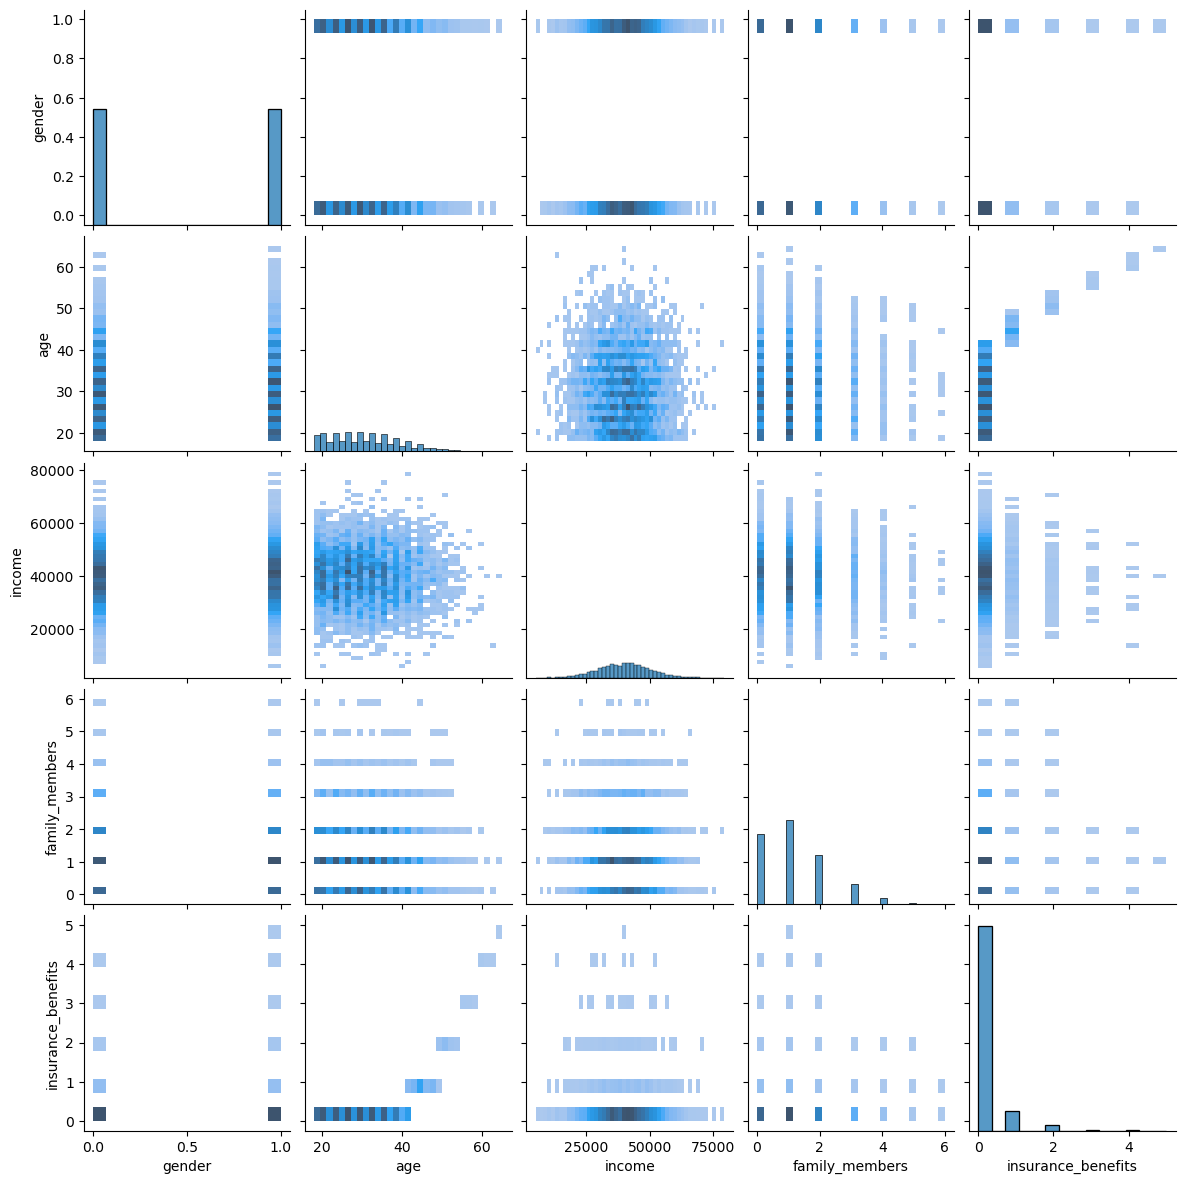

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Se escribirá una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Pruébalo para cuatro combinaciones de dos casos
- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3957,1.0,0.661538,0.429114,0.500000,1
356,1.0,0.461538,0.400000,0.500000,0
2089,1.0,0.600000,0.610127,0.333333,0
3066,0.0,0.323077,0.579747,0.500000,0
4943,1.0,0.630769,0.558228,0.000000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [16]:
get_knn(df, 10, 5, 'euclidean')

C:\Users\digom\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
10,1,25,36600,1,0,0.000000
4039,1,25,36600,2,0,1.000000
2037,1,26,36600,0,0,1.414214
3247,1,26,36600,2,0,1.414214
1508,0,26,36600,0,0,1.732051


In [17]:
get_knn(df, 10, 5, 'manhattan')

C:\Users\digom\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
10,1,25,36600,1,0,0.0
4039,1,25,36600,2,0,1.0
2037,1,26,36600,0,0,2.0
3247,1,26,36600,2,0,2.0
1508,0,26,36600,0,0,3.0


In [18]:
get_knn(df_scaled, 10, 5, 'euclidean')

C:\Users\digom\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1389,1.0,0.369231,0.464557,0.166667,0,0.015437
760,1.0,0.369231,0.462025,0.166667,0,0.015437
2254,1.0,0.400000,0.455696,0.166667,0,0.017157


In [19]:
get_knn(df_scaled, 10, 5, 'manhattan')

C:\Users\digom\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1389,1.0,0.369231,0.464557,0.166667,0,0.016650
760,1.0,0.369231,0.462025,0.166667,0,0.016650
2254,1.0,0.400000,0.455696,0.166667,0,0.022980


In [20]:
df.iloc[[10,4377,1389,760,2254]]

,gender,age,income,family_members,insurance_benefits
10,1,25,36600,1,0
4377,1,25,37400,1,0
1389,1,24,36700,1,0
760,1,24,36500,1,0
2254,1,26,36000,1,0


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Podemos apreciar que los resultados obtenidos difieren dependiendo de si la base de datos se encuentra escalada o no. En la base de datos no escalada podemos observar que se le da prioridad a la columna “income”, al poseer las mayores magnitudes numéricas con respecto a las demás columnas, cosa que no sucede con la base de datos escalada. 

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

En este caso, al utilizar las distancias euclidianas y de manhattan no podemos apreciar diferencias en los resultados ya sea con la base de datos original como con la escalada. 

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, se evaluará si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construir un clasificador basado en KNN y medir su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia.
- Construir un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probaremos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Dividiremos todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [21]:
df['insurance_benefits_received'] = (df['insurance_benefits'] == 0)
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] == 0)

In [22]:
df['insurance_benefits_received'].value_counts()

True     4436
False     564
Name: insurance_benefits_received, dtype: int64

Podemos apreciar que existe un claro desequilibrio de clases como se mencionó en la sección anterior.

In [23]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}') 
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

Crearemos una función resumida para evaluar qué número de k es el que arroja el mejor resultado.

In [24]:
def eval_classifier1(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    return f1_score

Procedemos a crear un modelo aleatorio que devuelva "1" para la columna "insurance_benefits_received" con las probabilidades anteriormente fijadas.

In [25]:
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [26]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.1128 0.    ]
 [0.8872 0.    ]]

La probabilidad: 0.89
F1: 0.89
Matriz de confusión
[[0.0134 0.0994]
 [0.0958 0.7914]]

La probabilidad: 0.50
F1: 0.63
Matriz de confusión
[[0.053  0.0598]
 [0.456  0.4312]]

La probabilidad: 1.00
F1: 0.94
Matriz de confusión
[[0.     0.1128]
 [0.     0.8872]]



Ahora procederemos a crear un modelo clasificador con la base de datos original como con la escalada, evaluaremos ambos modelos para valores de k de 1 a 10 y para los dos tipos de distancias euclidianas y manhattan.

In [27]:
features_df = df.drop('insurance_benefits_received', axis=1)
target_df = df['insurance_benefits_received']

In [28]:
features_train_df, features_valid_df, target_train_df, target_valid_df = train_test_split(
    features_df, target_df, test_size=0.3, random_state=12345)

In [29]:
best_model = None
best_score = 0
best_k = 0
for k in range(1,11):
    for distance in ('euclidean','manhattan'):
        model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric=distance)
        model.fit(features_train_df,target_train_df)
        predict = model.predict(features_valid_df)
        score = eval_classifier1(target_valid_df, predict)
        if score > best_score:
            best_model = model
            best_score = score
            best_k = k
            best_metric = distance
print("F1:", best_score, "k:", best_k, "metric:", best_metric)

C:\Users\digom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\digom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

F1: 0.9644297763109644 k: 1 metric: manhattan


C:\Users\digom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [30]:
features_df_scaled = df_scaled.drop('insurance_benefits_received', axis=1)
target_df_scaled = df_scaled['insurance_benefits_received']

In [31]:
features_train_df_scaled, features_valid_df_scaled, target_train_df_scaled, target_valid_df_scaled = train_test_split(
    features_df_scaled, target_df_scaled, test_size=0.3, random_state=12345)

In [32]:
best_model = None
best_score = 0
best_k = 0
for k in range(1,11):
    for distance in ('euclidean','manhattan'):
        model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric=distance)
        model.fit(features_train_df_scaled,target_train_df_scaled)
        predict = model.predict(features_valid_df_scaled)
        score = eval_classifier1(target_valid_df_scaled, predict)
        if score > best_score:
            best_model = model
            best_score = score
            best_k = k
            best_metric = distance
print("F1:", best_score, "k:", best_k, "metric:", best_metric)

C:\Users\digom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\digom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

F1: 1.0 k: 1 metric: euclidean


Podemos observar que para ambas bases de datos obtenemos modelos con un valor F1 mayor que para el modelo dummy, es de relevancia notar que con la base de datos escalada se obtuvo un modelo con un valor F1 máximo de 1.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, se evaluará cuál sería la RECM de un modelo de regresión lineal.

Procederemos a construir una implementación de regresión lineal. Comprobaremos la RECM tanto para los datos originales como para los escalados. ¿Se puede apreciar alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades
- $y$ — objetivo (un vector)
- $\hat{y}$ — objetivo estimado (un vector)
- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Dividiremos todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utilizaremos la métrica RECM para evaluar el modelo.

In [30]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = (np.linalg.inv(X2.T@X2))@(X2.T)@y 

    def predict(self, X):
        
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) 
        y_pred = X2@self.weights 
        
        return y_pred

In [31]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

Procederemos a construir el modelo de regresión lineal con los datos originales.

In [32]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43538930e-01  3.57495491e-02  1.64272730e-02 -2.60745684e-07
 -1.16902138e-02]
RMSE: 0.34
R2: 0.66


Continuaremos con el modelo de regresión lineal con los datos escalados.

In [33]:
X1 = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y1 = df_scaled['insurance_benefits'].to_numpy()

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=12345)

lr1 = MyLinearRegression()

lr1.fit(X1_train, y1_train)
print(lr1.weights)

y1_test_pred = lr1.predict(X1_test)
eval_regressor(y1_test, y1_test_pred)

[-0.94353893  2.32372069  0.01642727 -0.02059891 -0.07014128]
RMSE: 0.34
R2: 0.66


Finalmente, al comparar los resultados obtenidos de RMSE y R2 entre los modelos con la base de datos original y la base de datos escaladas no se aprecian diferencias en ambos parámetros.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas por una matriz invertible $P$. 

$$
X' = X \times P
$$

Posterior a realizarlo, comprobaremos cómo quedarán los valores de las características después de la transformación.

In [34]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [36]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [37]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [38]:
X_original = pd.DataFrame(X, columns = personal_info_column_list)
X_original.head()

,gender,age,income,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0


In [40]:
X_of = X @ P
X_ofuscada = pd.DataFrame(X_of, columns = personal_info_column_list)
X_ofuscada.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


Como podemos observar, con la matriz ofuscada no es posible adivinar la edad o ingresos de los clientes, no se puede observar algún patrón o algo que nos indique cual podrian ser los números reales.

Comprobaremos si podemos recuperar los datos.

In [41]:
X1 = X_of @ np.linalg.inv(P)
X_recuperada = pd.DataFrame(X1, columns = personal_info_column_list).round()
X_recuperada.head()

,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [42]:
X_original.loc[245]

gender                1
age                  25
income            52100
family_members        2
Name: 245, dtype: int64

In [43]:
X_ofuscada.loc[245]

gender             6679.136382
age               23491.582325
income            19339.350981
family_members    48305.259372
Name: 245, dtype: float64

In [44]:
X_recuperada.loc[245]

gender                1.0
age                  25.0
income            52100.0
family_members        2.0
Name: 245, dtype: float64

Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Cuando se procedió a recuperar la matriz original se redondearon los resultados debido a la existencia de múltiples decimales generados por la matriz aleatoria creada, lo anterior provoca que al recuperar la matriz original estos decimales afecten el resultado final en valores muy pequeños, por lo que redondeando la matriz obtenemos prácticamente los mismos valores que en la matriz original con detalles como que se observen como valores de tipo "float".

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

Al simplificar la nota apreciamos que wp es igual a w multiplicada por la inversa de la matriz P que utilizamos para ofuscar los datos, por lo cual los valores predichos por wp son los valores predichos por w multiplicados por la inversa de la matriz P. La calidad del RECM resultante debiera de ser igual que con la base de datos sin ofuscar ya que solo se están modificando las columnas características.

**Prueba analítica**

$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$
$$w_P = [P^T X^T XP]^{-1} P^T X^T y$$
$$w_P = P^{-1} (X^T X)^{-1} P^{-T} P^T X^T y$$
$$w_P = P^{-1} (X^T X)^{-1} X^T y$$
$$w_P = P^{-1} w$$

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [45]:
def LRegression(data, obfuscate = None):
    if obfuscate is None:
        features = data[['age', 'gender', 'income', 'family_members']].to_numpy()
        target = data['insurance_benefits'].to_numpy()
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)
        model = MyLinearRegression()
        model.fit(features_train, target_train)
        prediction = model.predict(features_test)
        return eval_regressor(target_test, prediction)
    else:
        X = data[['gender', 'age', 'income', 'family_members']].to_numpy()
        data1 = X @ obfuscate
        data2 = pd.DataFrame(data1, columns = ['age', 'gender', 'income', 'family_members'])
        features = data2[['age', 'gender', 'income', 'family_members']].to_numpy()
        target = data['insurance_benefits'].to_numpy()
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)
        model = MyLinearRegression()
        model.fit(features_train, target_train)
        prediction = model.predict(features_test)
        return eval_regressor(target_test, prediction)

In [46]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df_scaled[personal_info_column_list]
X = df_pn.to_numpy()

In [47]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [48]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [49]:
LRegression(df_scaled)

RMSE: 0.34
R2: 0.66


In [50]:
LRegression(df_scaled, P)

RMSE: 0.34
R2: 0.66


No se aprecian diferencias entre los resultados de la base de datos original y la ofuscada.

# Conclusiones

La primera tarea consistía en encontrar clientes que sean similares a un cliente determinado, para esto se utilizó un modelo en base al algoritmo K-Nearest-Neighbor, aquí se llegó a la conclusión que el hecho de escalar los datos afecta el resultado obtenido por el algoritmo al darles la misma importancia a todas las columnas características sin importar el rango de magnitud numérica que posean.

Como segunda tarea se procedió a predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro y se comparó el modelo con un modelo dummy creado para este caso. Se pudo concluir que los modelos elaborados lograron obtener valores F1 mayores que los entregados por el modelo dummy y el modelo que utilizo la base de datos escalada logro obtener el mayor valor F1 posible.  

Como tercera tarea se procedió a predecir el número de prestaciones de seguro que un nuevo cliente podría recibir utilizando un modelo de regresión lineal, en este caso al comparar los resultados obtenidos con la base de datos original y la escalada no se obtuvieron diferencias en los resultados.

Finalmente, como cuarta tarea se confeccionó un algoritmo de datos que enmascara las columnas características de los clientes para protección de los mismos, se logró obtener un modelo de regresión lineal que trabaja con los datos enmascarados sin afectar por ello la calidad del modelo en sí mismo.